# Pan Line 3 Coil Change Analysis

Dataset May 05, 2021 to December 02, 2025

1. Python configuration and requirements
   1. Create a Python virtual environment: `python3 -m venv ~/Python/venv/jupyter`
   2. Activate environment: `source ~/Python/venv/jupyter/bin/activate`
   3. Required packages are listed in _requirements.txt_ file
   4. Install required packages: `pip install -r requirements.txt`
2. Import Pan Line data and process: _data/Line 3 CoilUsage 2021_05_12-2025_12_02.csv_
   1. Set date data type for dates
   2. Extract year and day of year for production and load dates
   3. Extract stile gauge from Haas Smart Part Number
   4. Compare coil ID to previous to determine if the coil has changed
3. Create a data field with unique coils per day and coil changes per day


In [1]:
import pandas as pd
from IPython.display import Markdown as md
import stile_tools as st

# # Load the data
df = pd.read_csv('data/Line 3 CoilUsage 2021_05_12-2025_12_31.csv')

# # Set date type for date columns
df['DateTimeStamp'] = pd.to_datetime(df['DateTimeStamp'])
df['LoadDate'] = pd.to_datetime(df['LoadDate'])

# # Extract day of year and year from date columns
df['DayOfYear'] = df['DateTimeStamp'].dt.dayofyear
df['LoadDayOfYear'] = df['LoadDate'].dt.dayofyear
df['LoadYear'] = df['LoadDate'].dt.year
df['Year'] = df['DateTimeStamp'].dt.year
df['Month'] = df['DateTimeStamp'].dt.month

# # Make a column for the stile gauge
df['StileGauge'] = pd.to_numeric(df['SectionNumber'].str[12:13])

# # Make a copy of the CoilId column and shift down by one
# # then compare to see if the coil changed
df['IsCoilChange'] = df['HaasCoilNum'].shift(1) != df['HaasCoilNum']

# Get the 'Outside Panel Treatment' and 'Backer/Stile Placement Option' characters from the SectionNumber
df['StileCode'] = (df['SectionNumber'].str[8] +
                   df['SectionNumber'].str[19]) + "-SS"

# Get the 'Section Height' from the SectionNumber
df['SectionHeight'] = pd.to_numeric(df['SectionNumber'].str[1:3])

# Get the 'Section Length' from the SectionNumber
df['SectionLength'] = pd.to_numeric(
    df['SectionNumber'].str[14:16]) * 12 + pd.to_numeric(df['SectionNumber'].str[16:18])

print("Decoding stile codes from part number and calculating stile quantities...")
# Generate the stile key table, orphan stile codes, and orphan stile sections dataframe
stile_key_table, orphan_stile_codes, orphan_stile_df = st.gen_stile_key_table(
    df, 'data/PANEL LOCATIONS (LINE 3) Rev 03_20.xlsx', output=True)

# Remove rows that are in teh orphan_stile_df from df
print(
    f"Dropping {len(orphan_stile_df)} rows with orphan stile codes from main dataframe.")
df = df[~df['StileCode'].isin(orphan_stile_codes)].copy()

# Make a new column for StileQuantity using the stile key table to look up the value based on SectionLength and StileCode
df['StileQuantity'] = df.apply(
    lambda row: stile_key_table.at[row['SectionLength'], row['StileCode']], axis=1).fillna(0).astype(int)

df.to_csv('data/modified_coil_section_data.csv', index=False)

# Make a column for the weight of the stiles used in a section based on the StileGauge and SectionHeight
df['StileWeight'] = df.apply(st.calculate_stile_weight, axis=1)

# Calculate stile cost
df['StileCost'] = df.apply(st.calculate_stile_cost, axis=1)

# Generate summary markdown
data_preview = f"""
### Data Preview
There are {len(df)} pan sections across {df['Year'].nunique()} years. Below is a table of the first five rows of the DataFrame:
{df.head(5).to_markdown(index=False)}
"""

display(md(data_preview))

Decoding stile codes from part number and calculating stile quantities...
Sheet SJ-SS does NOT exist. Adding to orphan stile codes.
Sheet RW-SS does NOT exist. Adding to orphan stile codes.
Unique Stile Codes: ['SS-SS' 'SY-SS' 'SW-SS' 'CS-SS' 'NL-SS' 'BS-SS' 'NS-SS' 'NX-SS' 'N3-SS'
 'NW-SS' 'N2-SS' 'ND-SS' 'NA-SS' 'MS-SS' 'NC-SS' 'TS-SS' 'NF-SS' 'RS-SS'
 'NJ-SS' 'SA-SS' 'SD-SS' 'CW-SS' 'LS-SS' 'NY-SS' 'NZ-SS' 'CY-SS' 'UW-SS'
 'US-SS' 'BY-SS' 'BW-SS' 'SE-SS' 'RD-SS' 'SC-SS' 'BC-SS' 'NE-SS' 'CC-SS'
 'SX-SS' 'XS-SS' 'LW-SS' 'TW-SS' 'CD-SS' 'NM-SS' 'MY-SS' 'CE-SS' 'BD-SS'
 'CA-SS' 'UD-SS' 'NR-SS' 'MW-SS' 'N4-SS' 'UC-SS' 'NB-SS' 'BA-SS' 'N5-SS'
 'TY-SS' 'LY-SS' 'SJ-SS' 'MD-SS' 'UY-SS' 'TD-SS' 'NH-SS' 'GS-SS' 'TA-SS'
 'TC-SS' 'BE-SS' 'RW-SS' 'NK-SS' 'MC-SS' 'LD-SS' 'IF-SS' 'NV-SS' 'UA-SS'
 'DS-SS' 'N0-SS' 'N6-SS']
There were 9 sections with orphan stile codes added to the report: 'data/orphan_stiles_sections.csv'.
Dropping 9 rows with orphan stile codes from main dataframe.



### Data Preview
There are 1072549 pan sections across 5 years. Below is a table of the first five rows of the DataFrame:
| DateTimeStamp              | SectionNumber                  | HaasCoilNum                 | LoadDate            | IsCoilChange   |   DayOfYear |   LoadDayOfYear |   LoadYear |   Year |   Month |   StileGauge | StileCode   |   SectionHeight |   SectionLength |   StileQuantity |   StileWeight |   StileCost |
|:---------------------------|:-------------------------------|:----------------------------|:--------------------|:---------------|------------:|----------------:|-----------:|-------:|--------:|-------------:|:------------|----------------:|----------------:|----------------:|--------------:|------------:|
| 2021-05-12 00:00:08.607000 | T21PW-DBSS-N5-1000NS-NNNNN-NXN | PW-SC-DS-17-27.200-00044987 | 2021-05-13 00:00:00 | True           |         132 |             133 |       2021 |   2021 |       5 |            5 | SS-SS       |              21 |             120 |               4 |         7.208 |     3.99972 |
| 2021-05-12 00:00:35.673000 | B21PW-DBSS-N5-1000NS-NNNNN-NXL | PW-SC-DS-17-27.200-00044987 | 2021-05-13 00:00:00 | False          |         132 |             133 |       2021 |   2021 |       5 |            5 | SS-SS       |              21 |             120 |               4 |         7.208 |     3.99972 |
| 2021-05-12 00:01:03.290000 | I21PW-DBSS-N5-1000NS-NNNNN-NXN | PW-SC-DS-17-27.200-00044987 | 2021-05-13 00:00:00 | False          |         132 |             133 |       2021 |   2021 |       5 |            5 | SS-SS       |              21 |             120 |               4 |         7.208 |     3.99972 |
| 2021-05-12 00:01:31.227000 | I21PW-DBSS-N5-1000NS-NNNNN-NXN | PW-SC-DS-17-27.200-00044987 | 2021-05-13 00:00:00 | False          |         132 |             133 |       2021 |   2021 |       5 |            5 | SS-SS       |              21 |             120 |               4 |         7.208 |     3.99972 |
| 2021-05-12 00:01:58.243000 | T21PW-DBSS-N5-1000NS-NNNNN-NXN | PW-SC-DS-17-27.200-00044987 | 2021-05-13 00:00:00 | False          |         132 |             133 |       2021 |   2021 |       5 |            5 | SS-SS       |              21 |             120 |               4 |         7.208 |     3.99972 |


### Minimum Planned Coil Changes Per Day

#### How is it calculated?
- The minimum possible number of coil changes in a day would assume no section remakes.
- A planned coil change is derrived from the data by adding the unique combinations of coil IDs and stile gauges for a given load date.

### Average Planned Coil Changes per Day by Month:

| Month   |   2021 |   2022 |   2023 |   2024 |   2025 |
|:--------|-------:|-------:|-------:|-------:|-------:|
| Jan     |    0.0 |   31.9 |   34.3 |   35.5 |   36.9 |
| Feb     |    0.0 |   33.8 |   36.9 |   32.1 |   31.8 |
| Mar     |    0.0 |   33.8 |   39.6 |   30.4 |   35.8 |
| Apr     |    0.0 |   32.4 |   41.5 |   30.9 |   36.7 |
| May     |   34.2 |   37.0 |   43.7 |   40.0 |   40.5 |
| Jun     |   26.9 |   36.7 |   41.9 |   33.9 |   43.0 |
| Jul     |   29.3 |   39.0 |   41.7 |   35.9 |   41.1 |
| Aug     |   29.0 |   40.0 |   40.2 |   36.1 |   38.7 |
| Sep     |   26.1 |   40.0 |   41.0 |   38.8 |   38.0 |
| Oct     |   29.5 |   39.9 |   40.7 |   37.6 |   44.3 |
| Nov     |   29.2 |   40.0 |   37.6 |   39.6 |   45.4 |
| Dec     |   32.1 |   39.6 |   34.9 |   40.4 |   40.6 |

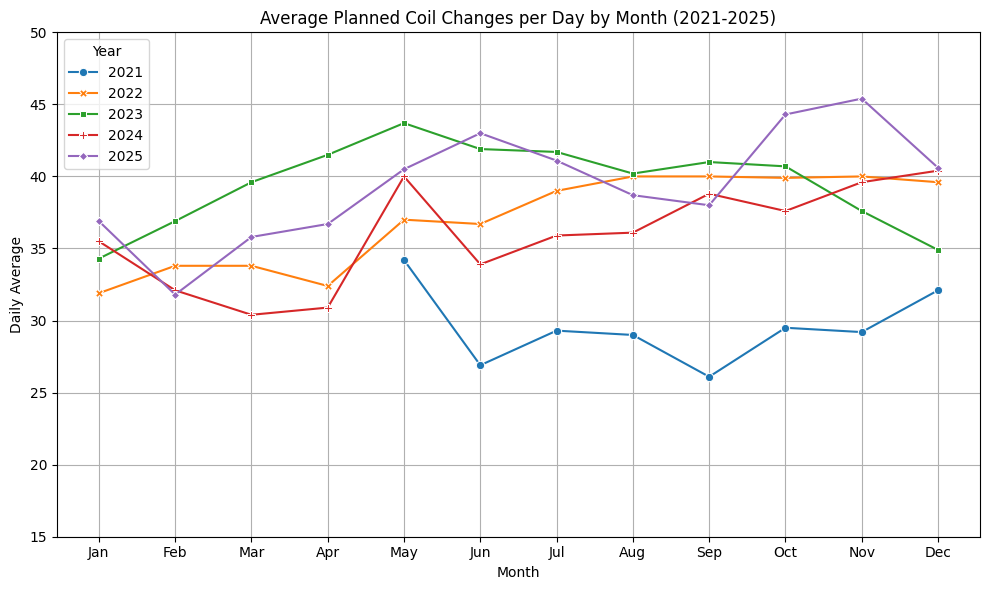

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

# Add a column that combines the CoilId and StileGauge for plotting
df['CoilIDStileGauge'] = df['HaasCoilNum'].astype(
    str) + '-' + df['StileGauge'].astype(str)

# Create a dataframe with the load date and count of unique CoilIDStileGauge per day
planned_coil_changes_df = df.groupby('LoadDate')[
    'CoilIDStileGauge'].nunique().reset_index()
planned_coil_changes_df.rename(
    columns={'CoilIDStileGauge': 'UniqueCoilStileGauges'}, inplace=True)

# Drop years before 2021 and after 2025
planned_coil_changes_df = planned_coil_changes_df[(planned_coil_changes_df['LoadDate'].dt.year >= 2021) & (
    planned_coil_changes_df['LoadDate'].dt.year <= 2025)]

# Calculate the daily average per month for each month of each individual year
planned_coil_changes_df['Month'] = planned_coil_changes_df['LoadDate'].dt.month
planned_coil_changes_df['Year'] = planned_coil_changes_df['LoadDate'].dt.year
planned_coil_changes_monthly_daily_avg_df = planned_coil_changes_df.groupby(
    ['Month', 'Year'])['UniqueCoilStileGauges'].mean().round(1).reset_index()
planned_coil_changes_monthly_daily_avg_df.rename(
    columns={'UniqueCoilStileGauges': 'AvgUniqueCoilStileGauges'}, inplace=True)

# Make the years the columns
planned_coil_changes_monthly_daily_avg_df = planned_coil_changes_monthly_daily_avg_df.pivot_table(index='Month',
                                                                                                  columns='Year',
                                                                                                  values='AvgUniqueCoilStileGauges',
                                                                                                  fill_value=0)

# Convert the month number to month name abbreviation for better readability
planned_coil_changes_monthly_daily_avg_df.index = planned_coil_changes_monthly_daily_avg_df.index.map(lambda x: calendar.month_abbr[x])

# Display the monthly average unique coil and stile gauge usage
display(md("### Average Planned Coil Changes per Day by Month:"))
display(md(planned_coil_changes_monthly_daily_avg_df.to_markdown(floatfmt=".1f")))


# Plot the monthly average unique coil and stile gauge usage ignoring zero values
plt.figure(figsize=(10, 6))
sns.lineplot(data=planned_coil_changes_monthly_daily_avg_df.replace(
    0, pd.NA), markers=True, dashes=False)
plt.title('Average Planned Coil Changes per Day by Month (2021-2025)')
plt.xlabel('Month')
plt.ylabel('Daily Average')
plt.ylim(15, 50)
plt.xticks(ticks=range(12), labels=[
           calendar.month_abbr[i] for i in range(1, 13)])
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/planned_minimum_coil_changes.png')
plt.show()

### Actual Coil Changes Per Day

#### How is it calculated?
- Since the boolean `IsCoilChange` is set to `True` each time the current coil is different from the previous, adding the `True` values for each day will reflect a daily coil-change count.
#### Potential issues
- In some cases Line 3 completes the sections for a given load date and starts working on another load date. When this happens a coil could be reloaded which would add coil changes to a work day making it seem less efficient. 

### Average Coil Changes per Day by Month:

| Month   |   2021 |   2022 |   2023 |   2024 |   2025 |
|:--------|-------:|-------:|-------:|-------:|-------:|
| Jan     |    0.0 |   22.8 |   27.9 |   28.9 |   28.2 |
| Feb     |    0.0 |   25.3 |   28.0 |   24.6 |   24.1 |
| Mar     |    0.0 |   26.1 |   28.9 |   24.2 |   24.1 |
| Apr     |    0.0 |   26.1 |   30.8 |   23.5 |   23.9 |
| May     |   32.8 |   28.0 |   30.7 |   31.5 |   26.5 |
| Jun     |   29.0 |   29.2 |   31.7 |   25.3 |   25.8 |
| Jul     |   24.4 |   27.8 |   31.5 |   27.0 |   29.0 |
| Aug     |   25.4 |   32.2 |   29.7 |   26.3 |   24.7 |
| Sep     |   20.0 |   30.7 |   28.8 |   26.6 |   26.0 |
| Oct     |   21.4 |   29.1 |   30.6 |   30.0 |   30.8 |
| Nov     |   26.0 |   29.0 |   27.2 |   29.2 |   28.8 |
| Dec     |   25.7 |   28.6 |   26.0 |   28.2 |   26.9 |

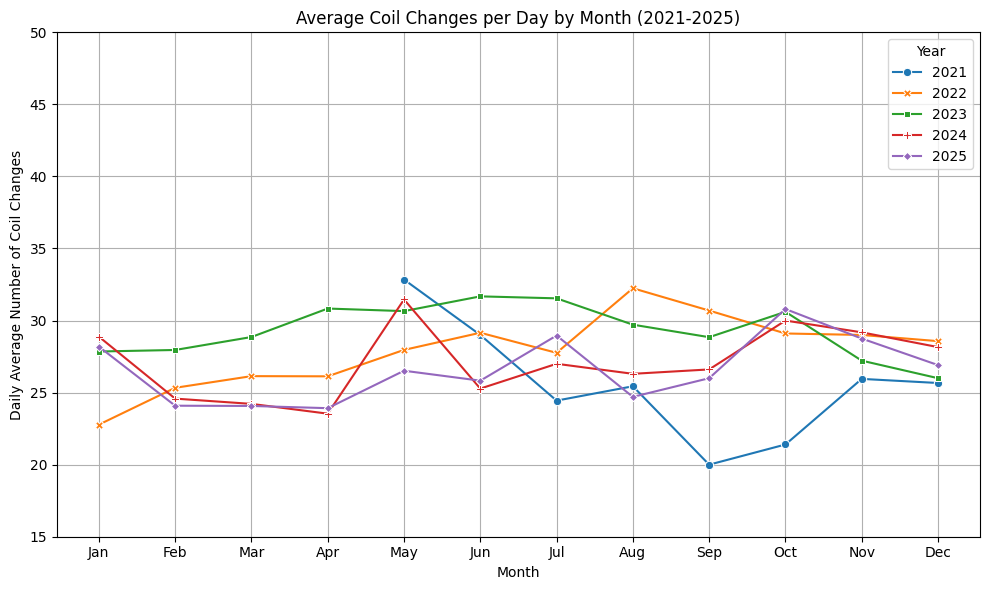

In [3]:

# Count the number of coils changed per day of each year
coils_changed_per_day_year = df.groupby(
    by=['Year', 'Month', 'DayOfYear'], group_keys=True)['IsCoilChange'].sum()

# Calculate the daily average per month for each month of each individual year
coils_changes_monthly_daily_avg_df = coils_changed_per_day_year.groupby(
    by=['Year', 'Month'], group_keys=True).mean()

# Set the pandas global display format for all floats to one decimal place
pd.set_option('display.float_format', '{:.1f}'.format)

# Pivot the cells so that the years are columns
coils_changes_monthly_daily_avg_df = coils_changes_monthly_daily_avg_df.unstack(level=0).fillna(0)

# Convert the month number to month name abbreviation for better readability
coils_changes_monthly_daily_avg_df.index = coils_changes_monthly_daily_avg_df.index.map(lambda x: calendar.month_abbr[x])

# Display the first few rows of the coils changed per day year dataframe
display(md("### Average Coil Changes per Day by Month:"))
display(md(coils_changes_monthly_daily_avg_df.to_markdown(floatfmt=".1f")))

# graph comparing years of coil changes per month
# set the y-axis range from 20 to 50
plt.figure(figsize=(10, 6))
sns.lineplot(data=coils_changes_monthly_daily_avg_df.replace(
    0, pd.NA), markers=True, dashes=False)
plt.title('Average Coil Changes per Day by Month (2021-2025)')
plt.xlabel('Month')
plt.ylabel('Daily Average Number of Coil Changes')
plt.ylim(15, 50)
plt.xticks(ticks=range(12), labels=[
           calendar.month_abbr[i] for i in range(1, 13)])
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/average_coil_changes_per_day_by_month.png')
plt.show()


### Working Ahead?

#### How often does Line 3 get into the next load date?
- For every work day, let's calculate how many times Line 3 works on more than one load date
#### Qualify working ahead
- What circumstanses other than working ahead would cause the line to work on multiple load dates?
  - Batching more than one load date for a coil/stile gauge combination
  - Section remakes
    - Let's assume that any work done for load dates earlier than the starting load date on a give work day are section remakes
  - Internal orders

In [4]:
# Count how many unique LoadDayOfYear there are for each DayOfYear per year
load_days_per_day_year = df.groupby(by=['Year', 'DayOfYear'], group_keys=True)[
    'LoadDayOfYear'].nunique()

# display(md(load_days_per_day_year.unstack(level=0).to_markdown()))

# What is the average number of load days per day of year per year?
avg_load_days_per_day_year = load_days_per_day_year.groupby('Year').mean().round(2)
avg_load_days_per_day_year = avg_load_days_per_day_year.rename('Avg Load Days/Day')
display(md(avg_load_days_per_day_year.to_markdown()))

# Try to remove section remakes
# For each DayOfYear and Year, make a list of LoadDayOfYear values in order of appearance allowing
# values to be repeated but not consecutively
load_days_list_per_day_year = df.groupby(by=['Year', 'DayOfYear'], group_keys=True)[
    'LoadDayOfYear'].apply(lambda x: [v for i, v in enumerate(x) if i == 0 or v != x.iloc[i-1]])

# Show as a markdown table
# display(md(load_days_list_per_day_year.unstack(level=0).to_markdown()))

load_days_list_per_day_year.unstack(level=0).to_excel('data/load_days_list_per_day_year.xlsx')


|   Year |   Avg Load Days/Day |
|-------:|--------------------:|
|   2021 |                2.69 |
|   2022 |                2.52 |
|   2023 |                2.83 |
|   2024 |                3.15 |
|   2025 |                3.55 |

### Coil Usage

| Month   |   2021 |   2022 |   2023 |   2024 |   2025 |
|:--------|-------:|-------:|-------:|-------:|-------:|
| Jan     |      0 |    146 |    134 |    140 |    143 |
| Feb     |      0 |    144 |    133 |    120 |    117 |
| Mar     |      0 |    157 |    150 |    112 |    134 |
| Apr     |      0 |    144 |    142 |    118 |    129 |
| May     |    116 |    148 |    167 |    162 |    138 |
| Jun     |    113 |    155 |    153 |    134 |    146 |
| Jul     |    105 |    146 |    137 |    122 |    146 |
| Aug     |    153 |    164 |    149 |    139 |    135 |
| Sep     |    148 |    141 |    133 |    128 |    144 |
| Oct     |    115 |    158 |    156 |    150 |    149 |
| Nov     |    124 |    127 |    136 |    141 |    148 |
| Dec     |    120 |    123 |    117 |    122 |    124 |

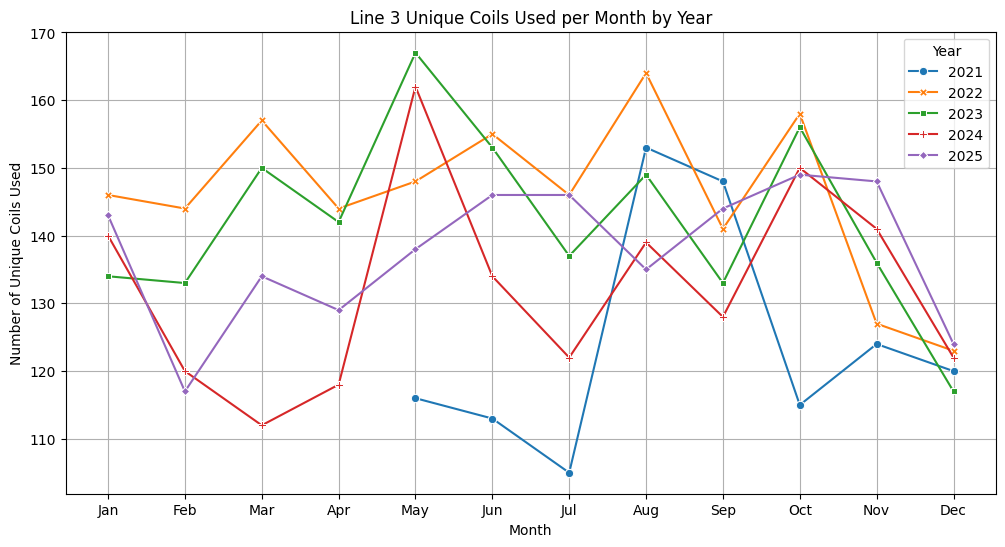

In [5]:
# Create a dataframe showing the number of unique coils used per month for each year
unique_coils_month = df.groupby(by=['Year', 'Month'], group_keys=True)[
    'HaasCoilNum'].nunique().unstack(level=0).fillna(0)
unique_coils_month.index = unique_coils_month.index.map(
    lambda x: pd.to_datetime(str(x), format='%m').strftime('%b'))

display(md(unique_coils_month.to_markdown()))

# replace 0 values with NaN to skip them in the plot
unique_coils_month = unique_coils_month.replace(0, pd.NA)

# graph comparing years of unique coils used per month
plt.figure(figsize=(12, 6))
sns.lineplot(data=unique_coils_month, markers=True, dashes=False)
plt.title('Line 3 Unique Coils Used per Month by Year')
plt.xlabel('Month')
plt.ylabel('Number of Unique Coils Used')
plt.legend(title='Year')
plt.grid(True)
plt.savefig('output/unique_coils_used_per_month_by_year.png')
plt.show()

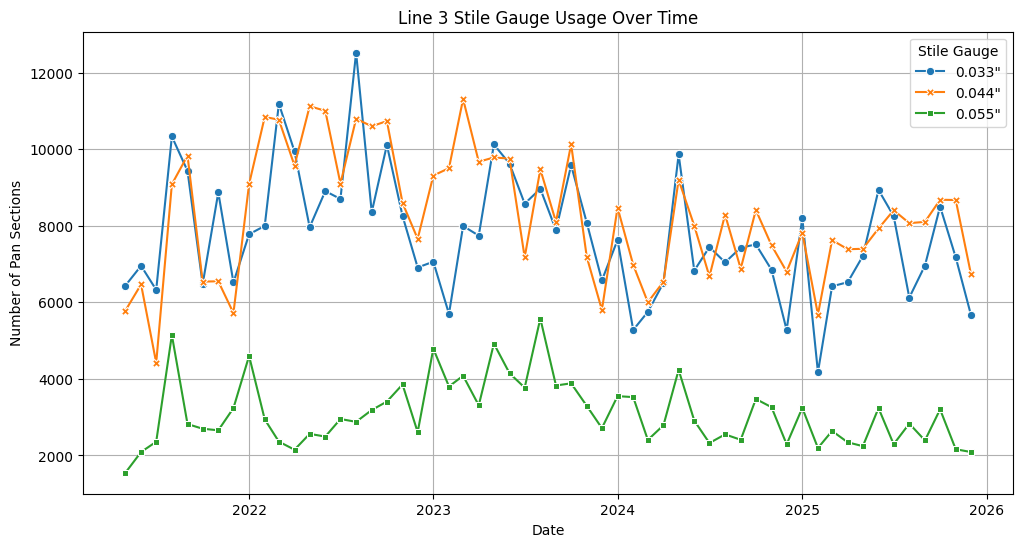

In [6]:
# Create a dataframe showing stile gauge usage over time from May 2021 to Dec 2025
stile_gauge_usage = df.groupby(by=['DateTimeStamp', 'StileGauge'], group_keys=True)[
    'SectionNumber'].count().unstack(level=1).fillna(0)
stile_gauge_usage = stile_gauge_usage.rename(columns=lambda x: f'0.0{x}{x}"')
stile_gauge_usage = stile_gauge_usage.resample('ME').sum()
stile_gauge_usage.index = stile_gauge_usage.index.to_period('M').to_timestamp()
# graph stile gauge usage over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=stile_gauge_usage, markers=True, dashes=False)
plt.title('Line 3 Stile Gauge Usage Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Pan Sections')
plt.legend(title='Stile Gauge')
plt.grid()
plt.savefig('output/stile_gauge_usage_over_time.png')
plt.show()

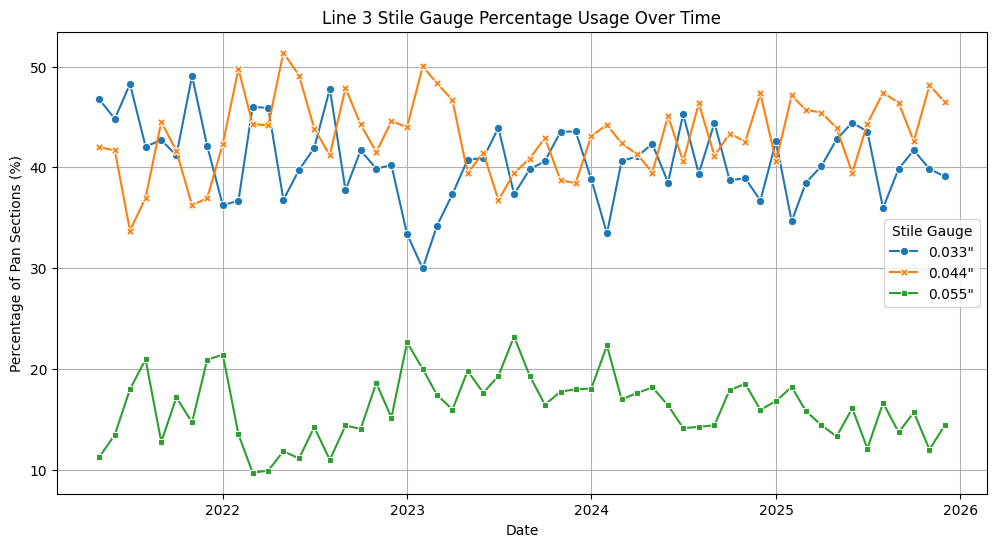

In [7]:
# Create a dataframe showing the percentage of stile gauge usage over time
stile_gauge_percentage = stile_gauge_usage.div(
    stile_gauge_usage.sum(axis=1), axis=0) * 100

# display(md(stile_gauge_percentage.to_markdown(floatfmt=".2f")))

# graph stile gauge percentage usage over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=stile_gauge_percentage, markers=True, dashes=False)
plt.title('Line 3 Stile Gauge Percentage Usage Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage of Pan Sections (%)')
plt.legend(title='Stile Gauge')
plt.grid()
plt.savefig('output/stile_gauge_percentage_usage_over_time.png')
plt.show()

### Stile Cost by Stile Gauge

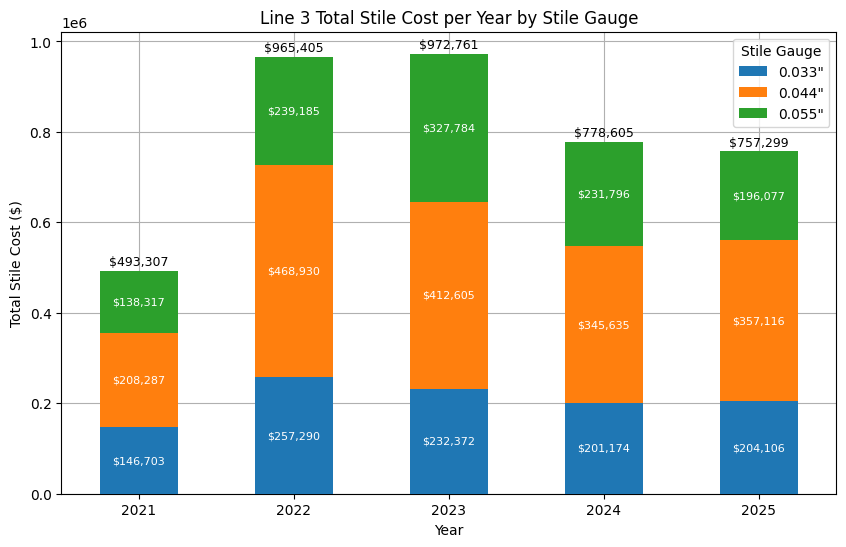

In [8]:
# Create a stacked bar plot of total stile cost per year per stile gauge
stile_cost_per_year = df.groupby(by=['Year', 'StileGauge'], group_keys=True)[
    'StileCost'].sum().unstack(level=1).fillna(0)
stile_cost_per_year = stile_cost_per_year.rename(columns=lambda x: f'0.0{x}{x}"')
ax = stile_cost_per_year.plot(kind='bar', stacked=True, zorder=3, figsize=(10, 6))
plt.title('Line 3 Total Stile Cost per Year by Stile Gauge')
plt.xlabel('Year')
plt.ylabel('Total Stile Cost ($)')
plt.legend(title='Stile Gauge')
plt.grid()
# Add dollar amounts on top of each bar segment
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.text(x + width/2, y + height/2, f'${height:,.0f}', ha='center', va='center', fontsize=8, color='white')
# Add the column totals above the bars
for i, total in enumerate(stile_cost_per_year.sum(axis=1)):
    ax.text(i, total + 5000, f'${total:,.0f}', ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=0)
plt.savefig('output/total_stile_cost_per_year_by_stile_gauge.png')
plt.show()

### Theoretical Scenarios
- Convert the 0.033" to 0.044"
- Convert both 0.033" and 0.044" to 0.055"

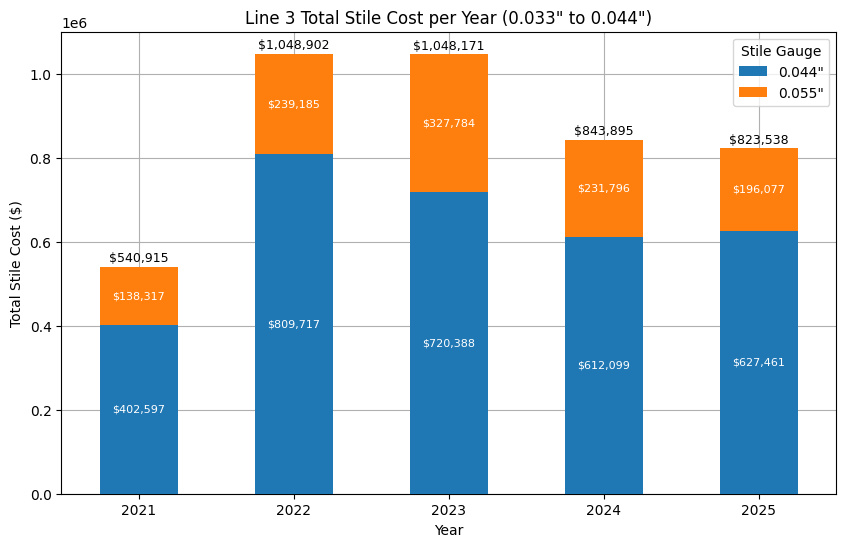

In [9]:
# Convert all the 3 gauge stiles to 4 gauge stiles and recalculate the stile weight and cost columns
df_3to4 = df.copy()
df_3to4[['StileGauge', 'StileWeight', 'StileCost']] = df_3to4.apply(st.convert_3_to_4_gauge, axis=1)
# convert the stile gauge to an integer
df_3to4['StileGauge'] = df_3to4['StileGauge'].astype(int)   
# Create a stacked bar plot of total stile cost per year per stile gauge after conversion
# show the dollar amounts in the bars
converted_stile_cost_per_year = df_3to4.groupby(by=['Year', 'StileGauge'], group_keys=True)[
    'StileCost'].sum().unstack(level=1).fillna(0)
converted_stile_cost_per_year = converted_stile_cost_per_year.rename(columns=lambda x: f'0.0{x}{x}"')
ax = converted_stile_cost_per_year.plot(kind='bar', stacked=True, zorder=3, figsize=(10, 6))
plt.title('Line 3 Total Stile Cost per Year (0.033" to 0.044")')
plt.xlabel('Year')
plt.ylabel('Total Stile Cost ($)')
plt.legend(title='Stile Gauge') 
plt.grid()
# Add dollar amounts on top of each bar segment
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.text(x + width/2, y + height/2, f'${height:,.0f}', ha='center', va='center', fontsize=8, color='white')
# Add the column totals above the bars
for i, total in enumerate(converted_stile_cost_per_year.sum(axis=1)):
    ax.text(i, total + 5000, f'${total:,.0f}', ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=0)
plt.savefig('output/total_stile_cost_per_year_by_stile_gauge_after_3_to_4_conversion.png')
plt.show()


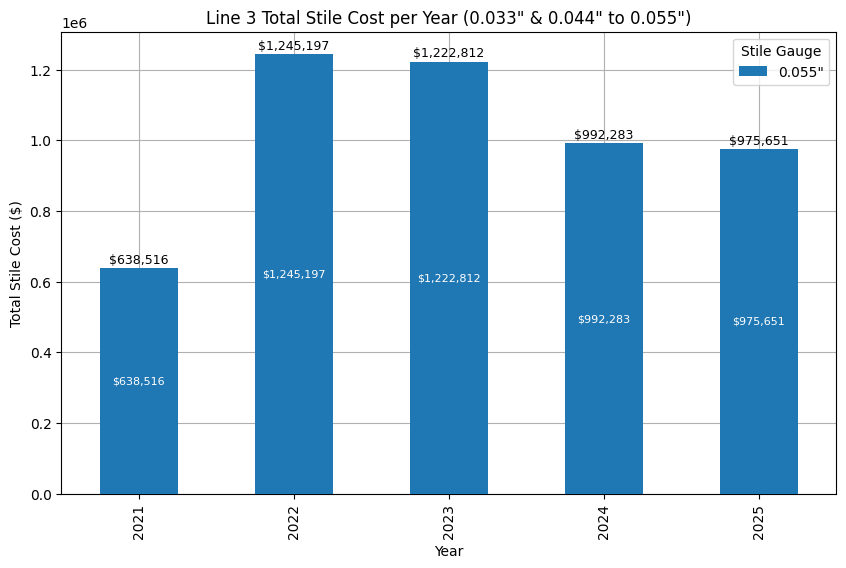

In [10]:
# Convert all the 3 and 4 gauge stiles to 5 gauge stiles and recalculate the stile weight and cost columns
df_3and4to5= df.copy()
df_3and4to5[['StileGauge', 'StileWeight', 'StileCost']] = df_3and4to5.apply(st.convert_3_4_to_5_gauge, axis=1)
# convert the stile gauge to an integer
df_3and4to5['StileGauge'] = df_3and4to5['StileGauge'].astype(int)   
# Create a stacked bar plot of total stile cost per year per stile gauge after conversion
# show the dollar amounts in the bars
converted_stile_cost_per_year = df_3and4to5.groupby(by=['Year', 'StileGauge'], group_keys=True)[
    'StileCost'].sum().unstack(level=1).fillna(0)
converted_stile_cost_per_year = converted_stile_cost_per_year.rename(columns=lambda x: f'0.0{x}{x}"')
ax = converted_stile_cost_per_year.plot(kind='bar', stacked=True, zorder=3, figsize=(10, 6))
plt.title('Line 3 Total Stile Cost per Year (0.033" & 0.044" to 0.055")')
plt.xlabel('Year')
plt.ylabel('Total Stile Cost ($)')
plt.legend(title='Stile Gauge') 
plt.grid()
# Add dollar amounts on top of each bar segment
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.text(x + width/2, y + height/2, f'${height:,.0f}', ha='center', va='center', fontsize=8, color='white')
# Add the column totals above the bars
for i, total in enumerate(converted_stile_cost_per_year.sum(axis=1)):
    ax.text(i, total + 5000, f'${total:,.0f}', ha='center', va='bottom', fontsize=9)
plt.savefig('output/total_stile_cost_per_year_by_stile_gauge_after_3_and_4_to_5_conversion.png')
plt.show()

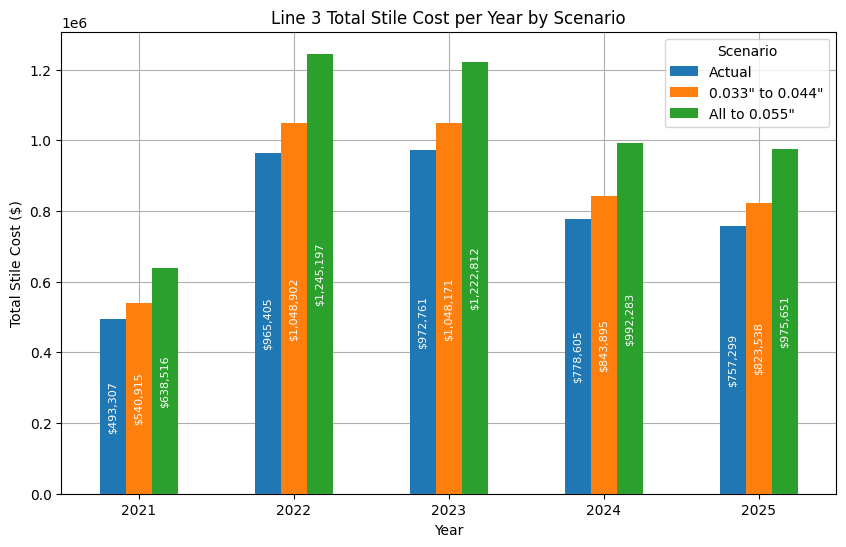

In [11]:
# Compare the total costs for each scenario for each year
total_cost_comparison = pd.DataFrame({
    'Actual': stile_cost_per_year.sum(axis=1),
    '0.033" to 0.044"': df_3to4.groupby(by=['Year'])['StileCost'].sum(),
    'All to 0.055"': df_3and4to5.groupby(by=['Year'])['StileCost'].sum()
})

# Graph the total costs for each scenario for each year
ax = total_cost_comparison.plot(kind='bar', zorder=3, figsize=(10, 6))
plt.title('Line 3 Total Stile Cost per Year by Scenario')
plt.xlabel('Year')
plt.ylabel('Total Stile Cost ($)')
plt.legend(title='Scenario')
plt.grid()
# Add dollar to teh center of each bar segment and rotate the dollar amounts for better readability
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.text(x + width/2, y + height/2, f'${height:,.0f}', ha='center', va='center', fontsize=8, color='white', rotation=90)
plt.xticks(rotation=0)
plt.savefig('output/total_stile_cost_per_year_by_scenario.png')
plt.show()


In [16]:
# For each DayOfYear, Year count the number of unique LoadDayOfYear where LoadDayOfYear is greater than DayOfYear
future_load_days_per_day = df[df['LoadDayOfYear'] > df['DayOfYear']].groupby(
    by=['Year', 'DayOfYear'], group_keys=True)['LoadDayOfYear'].nunique().reset_index()
future_load_days_per_day = future_load_days_per_day.rename(columns={'LoadDayOfYear': 'UniqueLoadDaysGreaterThanDayOfYear'})

# Calculate the average number of UniqueLoadDaysGreaterThanDayOfYear per month per year
future_load_days_per_day['Month'] = pd.to_datetime(future_load_days_per_day['DayOfYear'], format='%j').dt.month
avg_future_load_days_per_month_year = future_load_days_per_day.groupby(
    by=['Year', 'Month'], group_keys=True)['UniqueLoadDaysGreaterThanDayOfYear'].mean().round(2).unstack(level=0).fillna(0)

# Rename the index to month abbreviations
avg_future_load_days_per_month_year.index = avg_future_load_days_per_month_year.index.map(
    lambda x: calendar.month_abbr[x])

# Display the first few rows of the coil change analysis dataframe
display(md("### Average Future Load Days Per Day:"))
display(md(avg_future_load_days_per_month_year.to_markdown(floatfmt=".2f")))


### Average Future Load Days Per Day:

| Month   |   2021 |   2022 |   2023 |   2024 |   2025 |
|:--------|-------:|-------:|-------:|-------:|-------:|
| Jan     |   0.00 |   1.88 |   2.15 |   2.27 |   2.77 |
| Feb     |   0.00 |   1.75 |   2.21 |   2.17 |   3.14 |
| Mar     |   0.00 |   1.82 |   2.19 |   2.21 |   3.26 |
| Apr     |   0.00 |   2.17 |   2.12 |   2.32 |   3.04 |
| May     |   2.08 |   2.07 |   2.10 |   2.23 |   2.63 |
| Jun     |   2.35 |   2.12 |   1.71 |   3.08 |   2.90 |
| Jul     |   2.24 |   1.96 |   2.33 |   2.65 |   2.84 |
| Aug     |   2.12 |   1.90 |   2.07 |   3.08 |   3.11 |
| Sep     |   2.20 |   1.77 |   1.76 |   2.86 |   2.78 |
| Oct     |   2.04 |   1.45 |   2.04 |   3.08 |   3.16 |
| Nov     |   2.43 |   2.38 |   2.43 |   2.96 |   3.00 |
| Dec     |   2.12 |   1.65 |   2.06 |   2.47 |   3.00 |